# Survival analysis

This notebook presents example usage of package for solving survival problem on `bmt` dataset. You can access dataset [here](https://raw.githubusercontent.com/adaa-polsl/RuleKit/master/data/bmt/bmt.arff) 

This tutorial will cover topics such as:    
- training model   
- changing model hyperparameters   
- hyperparameters tuning   
- calculating metrics for model    

## Install dependencies

In [ ]:
%pip install matplotlib 

## Summary of the dataset

In [ ]:
import pandas as pd
import numpy as np
from rulekit.arff import read_arff

DATASET_URL: str = (
    'https://raw.githubusercontent.com/'
    'adaa-polsl/RuleKit/master/data/bmt/'
    'bmt.arff'
)
data_df: pd.DataFrame = read_arff(DATASET_URL)
data_df['survival_status'] = data_df['survival_status'].astype(int).astype(str)
data_df


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1,1,22.830137,0,1,0,1,1,1,0,...,1,7.20,1.338760,5.38,35.0,19.0,51.0,32.0,999.0,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,163.0,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0,435.0,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,None,4.25,29.481647,0.14,50.0,23.0,29.0,19.0,53.0,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,2043.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,...,1,11.08,2.522750,4.39,44.0,15.0,22.0,16.0,385.0,1
183,0,1,22.895890,0,0,0,1,0,1,1,...,1,4.64,1.038858,4.47,44.5,12.0,30.0,1000000.0,634.0,1
184,0,1,27.347945,0,1,0,1,-1,1,1,...,1,7.73,1.635559,4.73,33.0,16.0,16.0,1000000.0,1895.0,0
185,1,1,27.780822,0,1,0,1,0,1,1,...,0,15.41,8.077770,1.91,24.0,13.0,14.0,54.0,382.0,1


In [3]:
print("Dataset overview:")
print(f"Name: bmt")
print(f"Objects number: {data_df.shape[0]}; Attributes number: {data_df.shape[1]}")
print("Basic attribute statistics:")
data_df.describe()

Dataset overview:
Name: bmt
Objects number: 187; Attributes number: 37
Basic attribute statistics:


,Donorage,Recipientage,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time
count,187.000000,187.000000,187.000000,182.000000,182.000000,185.000000,187.000000,187.000000,187.000000,187.000000
mean,33.472068,9.931551,11.891781,5.385096,4.745714,35.801081,26752.866310,90937.919786,775408.042781,938.743316
std,8.271826,5.305639,9.914386,9.598716,3.859128,19.650922,161747.200525,288242.407688,418425.252689,849.589495
min,18.646575,0.600000,0.790000,0.204132,0.040000,6.000000,9.000000,9.000000,10.000000,6.000000
25%,27.039726,5.050000,5.350000,1.786683,1.687500,19.000000,13.000000,16.000000,1000000.000000,168.500000
50%,33.550685,9.600000,9.720000,2.734462,4.325000,33.000000,15.000000,21.000000,1000000.000000,676.000000
75%,40.117809,14.050000,15.415000,5.823565,6.785000,50.600000,17.000000,37.000000,1000000.000000,1604.000000
max,55.553425,20.200000,57.780000,99.560970,20.020000,103.400000,1000000.000000,1000000.000000,1000000.000000,3364.000000


## Helper function for creating ruleset characteristics dataframe

In [4]:
def get_ruleset_stats(model) -> pd.DataFrame:
    tmp = model.parameters.__dict__
    del tmp['_java_object']
    return pd.DataFrame.from_records([{**tmp, **model.stats.__dict__}])

## Rule induction on full dataset

In [5]:
X: pd.DataFrame = data_df.drop(['survival_status'], axis=1)
y: pd.Series = data_df['survival_status']

In [6]:
from rulekit.survival import SurvivalRules
from rulekit.rules import RuleSet, SurvivalRule

srv = SurvivalRules(survival_time_attr='survival_time')

srv.fit(X, y)

ruleset: RuleSet[SurvivalRule] = srv.model

predictions: np.ndarray = srv.predict(X)


ruleset_stats = get_ruleset_stats(ruleset)


display(ruleset_stats)

,minimum_covered,maximum_uncovered_fraction,ignore_missing,pruning_enabled,max_growing_condition,time_total_s,time_growing_s,time_pruning_s,rules_count,conditions_per_rule,induced_conditions_per_rule,avg_rule_coverage,avg_rule_precision,avg_rule_quality,pvalue,FDR_pvalue,FWER_pvalue,fraction_significant,fraction_FDR_significant,fraction_FWER_significant
0,0.05,0.0,False,True,0.0,1.771417,0.797513,0.902853,5,3.6,65.2,0.308021,1.0,0.999865,0.000135,0.000147,0.000184,1.0,1.0,1.0


## Plot predicted estimators for the first five examples

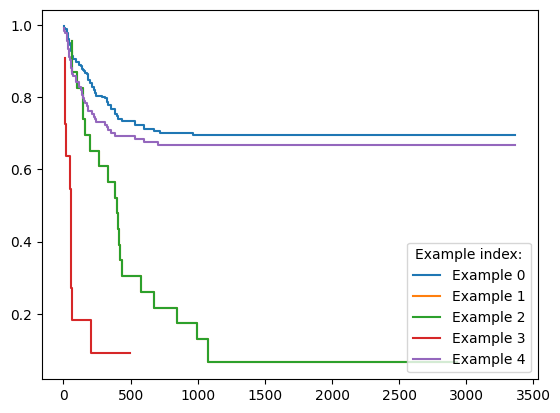

In [7]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.step(
        predictions[i]["times"],
        predictions[i]["probabilities"],
        label=f'Example {i}'
    )
plt.legend(title='Example index:')

## Plot rules Kaplan-Meier's estimators on top of the training dataset estimator

r1: IF Donorage = (-inf, 45.16) AND Relapse = {0} AND Recipientage = (-inf, 17.45) THEN 
r2: IF Donorage = (-inf, 43.63) AND HLAmismatch = {0} AND Relapse = {1} THEN 
r3: IF PLTrecovery = (-inf, 266) AND time_to_aGvHD_III_IV = <12.50, inf) AND ANCrecovery = <10.50, 19.50) AND Rbodymass = (-inf, 69) AND Donorage = (-inf, 44.06) AND Recipientage = <4.60, inf) AND CD34kgx10d6 = (-inf, 16.98) THEN 
r4: IF Donorage = <37.16, inf) AND Recipientage = <5.15, inf) AND time_to_aGvHD_III_IV = <23.50, inf) AND CD3dCD34 = <0.90, 73.72) THEN 
r5: IF Recipientage = <17.85, 18.85) THEN 


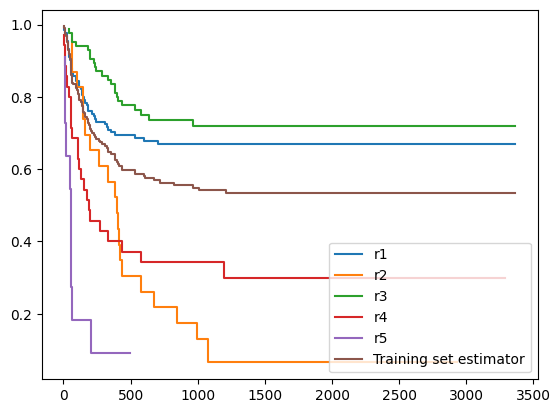

In [8]:
from rulekit.kaplan_meier import KaplanMeierEstimator

# plot rules kaplan-meier curves
for i, rule in enumerate(ruleset.rules):
    rule_label: str = f'r{i + 1}'
    rule_km: KaplanMeierEstimator = rule.kaplan_meier_estimator
    plt.step(
        rule_km.times,
        rule_km.probabilities,
        label=rule_label
    )
    print(f'{rule_label}: {rule}')

# plot whole dataset kaplan-meier curve
train_km: KaplanMeierEstimator = srv.get_train_set_kaplan_meier()
plt.step(
    train_km.times,
    train_km.probabilities,
    label='Training set estimator'
)

plt.legend()
plt.show()

### Rules evaluation on full set

In [9]:
integrated_brier_score = srv.score(X, y)
print(f'Integrated Brier Score: {integrated_brier_score}')

Integrated Brier Score: 0.19651358709002972


## Stratified K-Folds cross-validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from rulekit.exceptions import RuleKitJavaException

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

ruleset_stats = pd.DataFrame()
survival_metrics = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    srv = SurvivalRules(
        survival_time_attr='survival_time'
    )
    srv.fit(X_train, y_train)

    ruleset = srv.model

    ibs: float = srv.score(X_test, y_test)

    survival_metrics.append(ibs)
    ruleset_stats = pd.concat([ruleset_stats, get_ruleset_stats(ruleset)])

Ruleset characteristics (average)

In [11]:
display(ruleset_stats.mean())

minimum_covered                 0.050000
maximum_uncovered_fraction      0.000000
ignore_missing                  0.000000
pruning_enabled                 1.000000
max_growing_condition           0.000000
time_total_s                    0.799019
time_growing_s                  0.296248
time_pruning_s                  0.477474
rules_count                     4.000000
conditions_per_rule             2.581667
induced_conditions_per_rule    59.825000
avg_rule_coverage               0.486613
avg_rule_precision              1.000000
avg_rule_quality                0.995955
pvalue                          0.004045
FDR_pvalue                      0.004061
FWER_pvalue                     0.004104
fraction_significant            0.980000
fraction_FDR_significant        0.980000
fraction_FWER_significant       0.980000
dtype: float64

Rules evaluation on dataset (average)

In [12]:
print(f'Integrated Brier Score: {np.mean(survival_metrics)}')

Integrated Brier Score: 0.20178456199764142


## Hyperparameters tuning

This one gonna take a while...

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [14]:
def scorer(estimator: SurvivalRules, X: pd.DataFrame, y: pd.Series) -> float:
    return -1 * estimator.score(X, y)

In [18]:
# define models and parameters
model = SurvivalRules(survival_time_attr='survival_time')

# define grid search
grid = {
    'survival_time_attr': ['survival_time'],
    'minsupp_new': range(1, 10),
}

cv = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring=scorer)
grid_result = grid_search.fit(X, y)

# summarize results
print(
    'Best Integrated Brier Score: '
    f'{grid_result.best_score_} using {grid_result.best_params_}'
)

Best Integrated Brier Score: -0.21437408819868886 using {'minsupp_new': 3, 'survival_time_attr': 'survival_time'}


## Building model with tuned hyperparameters

### Split dataset to train and test (80%/20%)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

srv = SurvivalRules(
    survival_time_attr='survival_time',
    minsupp_new=5
)
srv.fit(X_train, y_train)
ruleset: RuleSet[SurvivalRule] = srv.model
ruleset_stats: pd.DataFrame = get_ruleset_stats(ruleset)

Rules evaluation

In [20]:
display(ruleset_stats.iloc[0])

minimum_covered                     5.0
maximum_uncovered_fraction          0.0
ignore_missing                    False
pruning_enabled                    True
max_growing_condition               0.0
time_total_s                   0.594173
time_growing_s                 0.244234
time_pruning_s                 0.312523
rules_count                           4
conditions_per_rule                2.25
induced_conditions_per_rule       55.25
avg_rule_coverage              0.389262
avg_rule_precision                  1.0
avg_rule_quality                    1.0
pvalue                              0.0
FDR_pvalue                          0.0
FWER_pvalue                         0.0
fraction_significant                1.0
fraction_FDR_significant            1.0
fraction_FWER_significant           1.0
Name: 0, dtype: object

### Validate model on test dataset

In [21]:
integrated_brier_score = srv.score(X_test, y_test)
print(f'Integrated Brier Score: {integrated_brier_score}')

Integrated Brier Score: 0.14054870564224475


In [22]:
predictions = srv.predict(X_test)

Text(0.5, 1.0, 'Predicted Kaplan-Meier curves for 5 examples from test set')

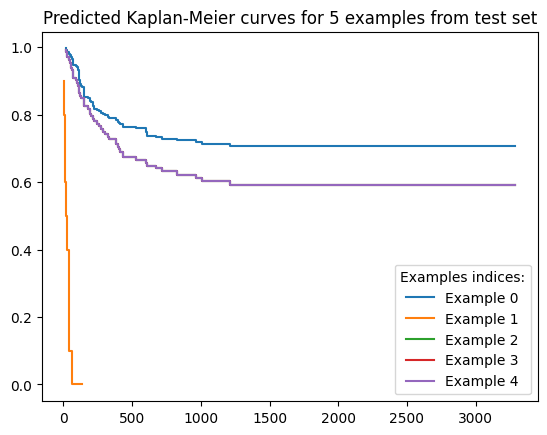

In [29]:
for i in range(5):
    plt.step(
        predictions[i]["times"], 
        predictions[i]["probabilities"],
        label=f'Example {i}'
    )
plt.legend(title='Examples indices:')
plt.title('Predicted Kaplan-Meier curves for 5 examples from test set')